# The Zero Order Hold trajectory leg

The zero order hold trajectory leg is implemented in `pykep` in the class {class}`pykep.leg.zoh`. Extending the concept of segments we find in the {class}`pykep.leg.sims_flanagan`, this leg accounts for a continuous thrust considered fixed in some frame along each segment of predefined length.

It thus approximates a thrust strategy via a sequence of continuous, constant thrust arcs (zero order hold). The leg is defined by a starting state $\mathbf x_s = [\mathbf r_s, \mathbf v_s, m_s]$, a final state $\mathbf x_f = [\mathbf r_f, \mathbf v_f, m_f]$ and a time grid defining the various segment lengths.

A sequence of controls $\mathbf u = [T_0, i_{x0}, i_{y0}, i_{z0}, T_1, i_{x1}, i_{y1}, i_{z1}, T_2, i_{x2}, i_{y2}, i_{z2}, ... ]$ define the magnitude and direction of the continuous thrust vector along each segment).

In this tutorial we show the basic API to interface with the class {class}`pykep.leg.zoh` efficiently.

We start with some imports:

In [1]:
import pykep as pk
import heyoka as hy
import numpy as np
import pygmo as pg

%matplotlib ipympl

In [2]:
# The integrators (Keplerian)
tol=1e-12
tol_var = 1e-6

ta_global = pk.ta.get_zoh_kep(tol)
ta_var_global = pk.ta.get_zoh_kep_var(tol_var)


# We test the zero hold leg

In [3]:
# To compute numerical gradients its convenientto have this API
def compute_mismatch_constraints_n(leg, state0, controls, state1, tgrid):
    # Forward segments
    leg.ta.time = tgrid[0]
    leg.ta.state[:] = state0
    for i in range(leg.nseg_fwd):
        # setting T, ix, iy, iz
        leg.ta.pars[0:4] = controls[4 * i : 4 * i + 4]
        # propagating
        leg.ta.propagate_until(tgrid[i + 1])
    state_fwd = leg.ta.state.copy()

    # Backward segments
    leg.ta.time = tgrid[-1]
    leg.ta.state[:] = state1
    for i in range(leg.nseg_bck):
        # setting T, ix, iy, iz
        leg.ta.pars[0] = controls[-4 * i - 4]
        leg.ta.pars[1] = controls[-4 * i - 3]
        leg.ta.pars[2] = controls[-4 * i - 2]
        leg.ta.pars[3] = controls[-4 * i - 1]
        # propagating
        leg.ta.propagate_until(tgrid[-2 - i])
    state_bck = leg.ta.state
    return (state_fwd - state_bck).tolist()

In [4]:
# We create a ballistic leg 
t0 = 10000
t1 = 10400
pl0 = pk.planet(pk.udpla.jpl_lp("Earth"))
pl1 = pk.planet(pk.udpla.jpl_lp("Mars"))
r0, v0 = pl0.eph(t0)
r1, v1 = pl1.eph(t1)
l = pk.lambert_problem(r0=r0, r1=r1, tof = (t1-t0) * pk.DAY2SEC, mu = pk.MU_SUN)
m0 = 1000
m1 = 1000


# Instantiate the leg (ballistic so all T are 0)
# nd units
L = pk.AU
MU = pk.MU_SUN
TIME = np.sqrt(L**3/MU)
V =  L/TIME
ACC = V/TIME
MASS = 1000
F = MASS*ACC

# leg data
nseg = int(np.random.uniform(4, 20))
veff = np.random.uniform(2000, 7000) * pk.G0

# nd data
state0 = [it/L for it in r0] + [it/V for it in l.v0[0]] + [m0/MASS]
state1 = [it/L for it in r1] + [it/V for it in l.v1[0]] + [m1/MASS]
veff_nd = veff / V
tgrid = np.linspace(t0*pk.DAY2SEC/TIME, t1*pk.DAY2SEC/TIME, nseg+1)

uixiyiz = np.random.uniform(-1,1, (4*nseg,)) * 1e-3

cut = np.random.uniform(0,1)

ta_global.pars[4] = 1. / veff_nd
ta_var_global.pars[4] = 1. / veff_nd

leg = pk.leg.zoh(state0, uixiyiz.tolist(), state1, tgrid, cut = cut, tas = [ta_global, ta_var_global])


In [6]:
pk.leg.__dir__()

['__name__',
 '__doc__',
 '__package__',
 '__loader__',
 '__spec__',
 '__path__',
 '__file__',
 '__cached__',
 '__builtins__',
 '_sims_flanagan',
 '_sims_flanagan_alpha',
 '_sims_flanagan_hf',
 '_sims_flanagan_hf_alpha',
 'sims_flanagan',
 'sims_flanagan_alpha',
 'sims_flanagan_hf',
 'sims_flanagan_hf_alpha',
 '_zoh',
 'zoh']

In [24]:
# Chack on dmc/dx0
grad_an = leg.compute_mc_grad()[0]
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg, x, leg.controls, leg.state1, leg.tgrid), leg.state0).reshape(7,-1)
np.linalg.norm(grad_num-grad_an)

7.5644676325105846e-08

In [25]:
# Chack on dmc/dxf
grad_an = leg.compute_mc_grad()[1]
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg, leg.state0, leg.controls, x, leg.tgrid), leg.state1).reshape(7,-1)
np.linalg.norm(grad_num-grad_an)

2.569058229236794e-07

In [26]:
# Chack on dmc/dcontrols
grad_an = leg.compute_mc_grad()[2]
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg, leg.state0, x, leg.state1, leg.tgrid), leg.controls, dx=1E-7).reshape(7,-1)
np.linalg.norm(grad_num-grad_an)

1.7200336429673122e-08

In [27]:
grad_an = leg.compute_mc_grad()[3]
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg, leg.state0, leg.controls, leg.state1, x), leg.tgrid).reshape(7,-1)
np.linalg.norm(grad_num-grad_an)

1.37024105886157e-08

Now the gradient is always well defined, non nans:

In [28]:
leg = pk.leg.zoh(state0, [0.1,0.2,0.3,0.4]*6, state1, np.linspace(0,400, 7)*pk.DAY2SEC/TIME, cut = cut, tas = [ta_global, ta_var_global])
dmcdx0, dmcdu, dmcdxf, dmdtgrid = leg.compute_mc_grad()
dmcdu

array([[ -4.48101561e+00,  -3.76027728e+00,  -2.80090283e-01,
          9.68199412e+00,   2.23643324e+00,   7.91696858e-01,
          3.25064860e-01],
       [ -1.39764819e+00,  -7.70833843e-01,  -6.41614669e-02,
          7.58020946e-01,   3.16616077e+00,   1.56742336e-02,
          1.99816364e-01],
       [ -5.81006113e-01,  -4.27572141e-01,   4.28388756e-01,
          1.02332879e+00,   2.46584571e-01,   2.60488027e+00,
          2.83194206e-01],
       [  1.94183287e+00,   1.77982500e+00,   1.24016423e-01,
         -4.61235044e+00,  -8.06152952e-01,  -6.42952332e-01,
         -1.79678085e-01],
       [ -3.11880160e-01,  -6.64010789e-01,  -1.02573216e-02,
          8.61872579e-01,   1.62502880e-01,   1.41518863e-01,
         -2.25217524e-02],
       [  4.41466784e-01,   3.49068725e-01,  -3.55633070e-01,
         -9.51364973e-01,  -1.35822152e-01,   1.48564303e-03,
         -9.80154219e-02],
       [ -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         -0.00000000e+00,  -0.00

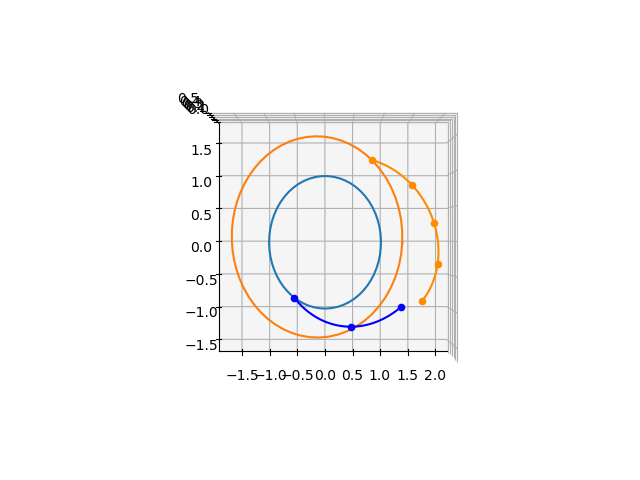

In [29]:
ax = pk.plot.make_3Daxis()
pk.plot.add_planet_orbit(ax, pl0, units=pk.AU)
pk.plot.add_planet_orbit(ax, pl1, units=pk.AU)
leg.add_to_3Daxis(ax, plot_time_grid=True)

ax.view_init(90,-90)


In [30]:
def numtc(x):
    leg.controls = x
    return leg.compute_throttle_constraints()
numtc(leg.controls)

[-0.71, -0.71, -0.71, -0.71, -0.71, -0.71]

In [14]:
pg.estimate_gradient(numtc, leg.controls).reshape(leg.nseg,-1)

array([[ 0.        ,  0.4       ,  0.59999999,  0.8       ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.4       ,  0.59999999,  0.8       ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.4       ,
         0.59999999,  0.8       ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
  

In [15]:
leg.compute_tc_grad()

array([[ 0.        ,  0.4       ,  0.6       ,  0.8       ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.4       ,  0.6       ,  0.8       ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.4       ,
         0.6       ,  0.8       ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
  